In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial import distance

In [10]:
class node:
    def __init__(self, x, y, indPre=0):
        self.x = [x]
        self.y = [y]
        self.indPre = [indPre]
        
class path:
    def __init__(self, x, y):
        self.x = [x]
        self.y = [y]

In [11]:
def line_check(axis1, axis2, gray_img):
    limit_range = 5
    if axis1[1] > axis2[1]:
        y_list = np.arange(int(axis2[1])-limit_range,int(axis1[1])+limit_range)
    elif axis1[1] < axis2[1]:
        y_list = np.arange(int(axis1[1])-limit_range, int(axis2[1])+limit_range)
    else:
        y_list = np.arange(int(axis1[1])-limit_range, int(axis1[1])+limit_range)
        
    if axis1[0] > axis2[0]:
        x_list = np.arange(int(axis2[0])-limit_range,int(axis1[0])+limit_range)
    elif axis1[0] < axis2[0]:
        x_list = np.arange(int(axis1[0])-limit_range, int(axis2[0])+limit_range)
    else:
        x_list = np.arange(int(axis1[0])-limit_range, int(axis1[0])+limit_range)
    
    for y in y_list:
        for x in x_list:
            gray_num = gray_img[y][x][0]
            if gray_num <= 205:
                return 1
    return 0

def check_in_boundary(axis, gray_img, limit_range):
    y_list = np.arange(int(axis[1])-limit_range, int(axis[1])+limit_range)
    x_list = np.arange(int(axis[0])-limit_range, int(axis[0])+limit_range)
    for y in y_list:
        for x in x_list:
            gray_num = gray_img[y][x][0]   
            if gray_num <= 205:
                return 1
    return 0

def recursive_refine(refining_path):
    length = len(refining_path[0])
    min_angle = 9999999
    min_angle_index = 0
    
    for i in range(1, length):
        x_diff = refining_path[0][0] - refining_path[0][i]
        y_diff = refining_path[1][0] - refining_path[1][i]
        angle = abs(math.atan(y_diff/x_diff) * (180/math.pi))
        
        CheckInBound = check_in_boundary([refining_path[0][i], refining_path[1][i]], gray_img, 15)
        if CheckInBound == 1:
            continue
        
        if min_angle > angle:
            min_angle = angle
            min_angle_index = i
            
    refined_path[0].append(refining_path[0][0])
    refined_path[1].append(refining_path[1][0])
    refining_path = [refining_path[0][min_angle_index:], refining_path[1][min_angle_index:]]
    
    if len(refining_path[0][min_angle_index:]) != 1:
        recursive_refine(refining_path)
    
def PathRefine(path):
    global refined_path
    pathLength = len(path.x)
    vector_x_pos = []
    vector_y_pos = []

    for i in range(pathLength):
        vector_x_pos.append(path.x[i])
        vector_y_pos.append(path.y[i])
    
    tempPath_refine = [vector_x_pos, vector_y_pos]
    refined_path = [[], []]        
    recursive_refine(tempPath_refine)
    
    return refined_path

In [12]:
def find_near_neighbor(node, new_axis, set_radius):
    index = []
    for i in range(len(node.x)):
        x_neighbor = [node.x[i], node.y[i]]
        if distance.euclidean(new_axis, x_neighbor) < set_radius:
            index.append(i)
            
    return index

def make_cost(pre, cur, add):
    cur_angle = math.degrees(math.atan2(add[1]-cur[1],add[0]-cur[0]))
    pre_angle = math.degrees(math.atan2(cur[1]-pre[1],cur[0]-pre[0]))
    diff_angle = abs(pre_angle-cur_angle)
    dist = distance.euclidean(add, cur)
    
    cost = diff_angle + dist
    
    return cost

def bermuda(indPre, index):
    tmp_index = indPre[index]
    while True:
        if tmp_index == index:
            return 1
        else:
            tmp_index = indPre[tmp_index]
        
        if tmp_index == 0:
            break
            
    return 0

In [13]:
def RRT(node, path, start, end, range_num):
    m = 0
    pcount = 0
    bcount = 0
    for i in range(1, range_num):
        if i == 1000 or i == 3000:
            m += 1
        x_rand = [START[m][0] + (END[m][0]-START[m][0])* np.random.rand(1), START[m][1] + (END[m][1]-START[m][1])* np.random.rand(1)]
#        x_rand = [robot[0] + (goal[0]-robot[0])* np.random.rand(1), robot[1] + (goal[1]-robot[1])* np.random.rand(1)]
        
        min_dist = 9999999
        near_iter = 0
        min_cost = 9999999
        cost_iter = 0
        N = len(node.x)
   
        for j in range(N):
            x_near = [node.x[j], node.y[j]]
            dist = distance.euclidean(x_rand, x_near)
            if min_dist > dist:
                min_dist = dist
                near_iter = j
            
        x_near = [node.x[near_iter], node.y[near_iter]]
            
        near_rand = [x_rand[0]-x_near[0], x_rand[1]-x_near[1]]
        normlized = [near_rand[0] / distance.euclidean(x_rand, x_near)*stepsize, near_rand[1] / distance.euclidean(x_rand, x_near)*stepsize]
        x_new = [x_near[0] + normlized[0], x_near[1] + normlized[1]] 
        
        CheckInBoundNew = check_in_boundary(x_new, gray_img, 10)
        LineCheck1 = line_check(x_new, x_near, gray_img)
        
        if CheckInBoundNew == 1 or LineCheck1 == 1:
            continue
        ######### choose parent #########    
        neighbor_index = find_near_neighbor(node, x_new, 20)
        if neighbor_index:
            for k in neighbor_index:
                cur_cost = [node.x[k], node.y[k]]
                pre_cost = [node.x[node.indPre[k]], node.y[node.indPre[k]]]
                cost = make_cost(pre_cost, cur_cost, x_new)
                    
                if min_cost > cost:
                    min_cost = cost
                    cost_iter = k
        
        x_cost = [node.x[cost_iter], node.y[cost_iter]]
        
        LineCheck2 = line_check(x_new, x_cost, gray_img)
        
        if LineCheck2 == 1:
            continue
        
        node.x.append(x_new[0])
        node.y.append(x_new[1])
        node.indPre.append(cost_iter)
        new_iter = len(node.x)-1
        ax.plot([x_cost[0], x_new[0]], [x_cost[1], x_new[1]], 'b-', linewidth=2)
        
        if distance.euclidean(x_new, end) < 0.001:
            break
        #################################
        ############# rewire ############
        new_child_index_list = [] 
        
        if neighbor_index:
            for i in neighbor_index:
                if i != cost_iter and i != 0:
                    x_child = [node.x[i], node.y[i]]
                    x_parent = [node.x[node.indPre[i]], node.y[node.indPre[i]]]
                    x_grand_parent = [node.x[node.indPre[node.indPre[i]]], node.y[node.indPre[node.indPre[i]]]]
                    new_cost = make_cost(x_cost, x_new, x_child)
                    neighbor_cost = make_cost(x_grand_parent, x_parent, x_child)
                    
                    if new_cost < neighbor_cost:
                        LineCheck3 = line_check(x_child, x_new, gray_img)
                        if LineCheck3 == 1:
                            continue
                
                        new_child_index_list.append(i)
                        
        if new_child_index_list:
            for k in new_child_index_list:
                pre_iter = node.indPre[k]
                new_child = [node.x[k], node.y[k]] 
                node.indPre[k] = new_iter
                Bermuda = bermuda(node.indPre, k)
                if Bermuda == 1:
                    node.indPre[k] = pre_iter
                    continue
                
                ax.plot([x_new[0], new_child[0]], [x_new[1], new_child[1]], 'b-', linewidth=2)
        #################################
    if True:
        path.x[0] = end[0]
        path.y[0] = end[1]
        path.x.append(node.x[-1])
        path.y.append(node.y[-1])
        path_index = node.indPre[-1]
    
        while True:
            path.x.append(node.x[path_index])
            path.y.append(node.y[path_index])
            path_index = node.indPre[path_index]

            if path_index == 0:
                break

        path.x.append(start[0])
        path.y.append(start[1])
        Range_Num = len(path.x)
        for j in range(1, Range_Num):
            ax.plot([path.x[j], path.x[j-1]], [path.y[j], path.y[j-1]], 'r:', linewidth=2)
    
    else:
        print('no path to end')

In [14]:
def set_params():
    global stepsize, robot, goal, v, pos, START, END
    stepsize = 10
    robot = [50, 150]
    goal = [220, 1350]
    START = [[50, 130], [1250, 130], [1250, 1250]]
    END = [[1400, 180], [1400, 1300], [220, 1360]]
    v = node(robot[0], robot[1])
    pos = path(0, 0)

In [15]:
def station():
    set_params()
    global img, gray_img, fig, ax
    img = cv2.imread('obstacle.jpg')

    gray_img = np.asarray(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    binary = cv2.bitwise_not(binary)

    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_title('Local map with an obstacle and line constraints', fontsize=40)
    ax.imshow(img)

    ax.set_xlim([0, 1500])
    ax.set_ylim([0, 1440])
   
    ax.plot(robot[0], robot[1], 'rd', markersize = 10, linewidth=1)
    ax.plot(goal[0], goal[1], 'rd', markersize = 10, linewidth=1)

    RRT(v, pos, robot, goal, 6001)
'''
    Final_path = PathRefine(pos)
    final_length = len(Final_path[0])

    for i in range(final_length-1):
        ax.plot([Final_path[0][i], Final_path[0][i+1]], [Final_path[1][i], Final_path[1][i+1]],  'k--', linewidth=2)
'''

"\n    Final_path = PathRefine(pos)\n    final_length = len(Final_path[0])\n\n    for i in range(final_length-1):\n        ax.plot([Final_path[0][i], Final_path[0][i+1]], [Final_path[1][i], Final_path[1][i+1]],  'k--', linewidth=2)\n"

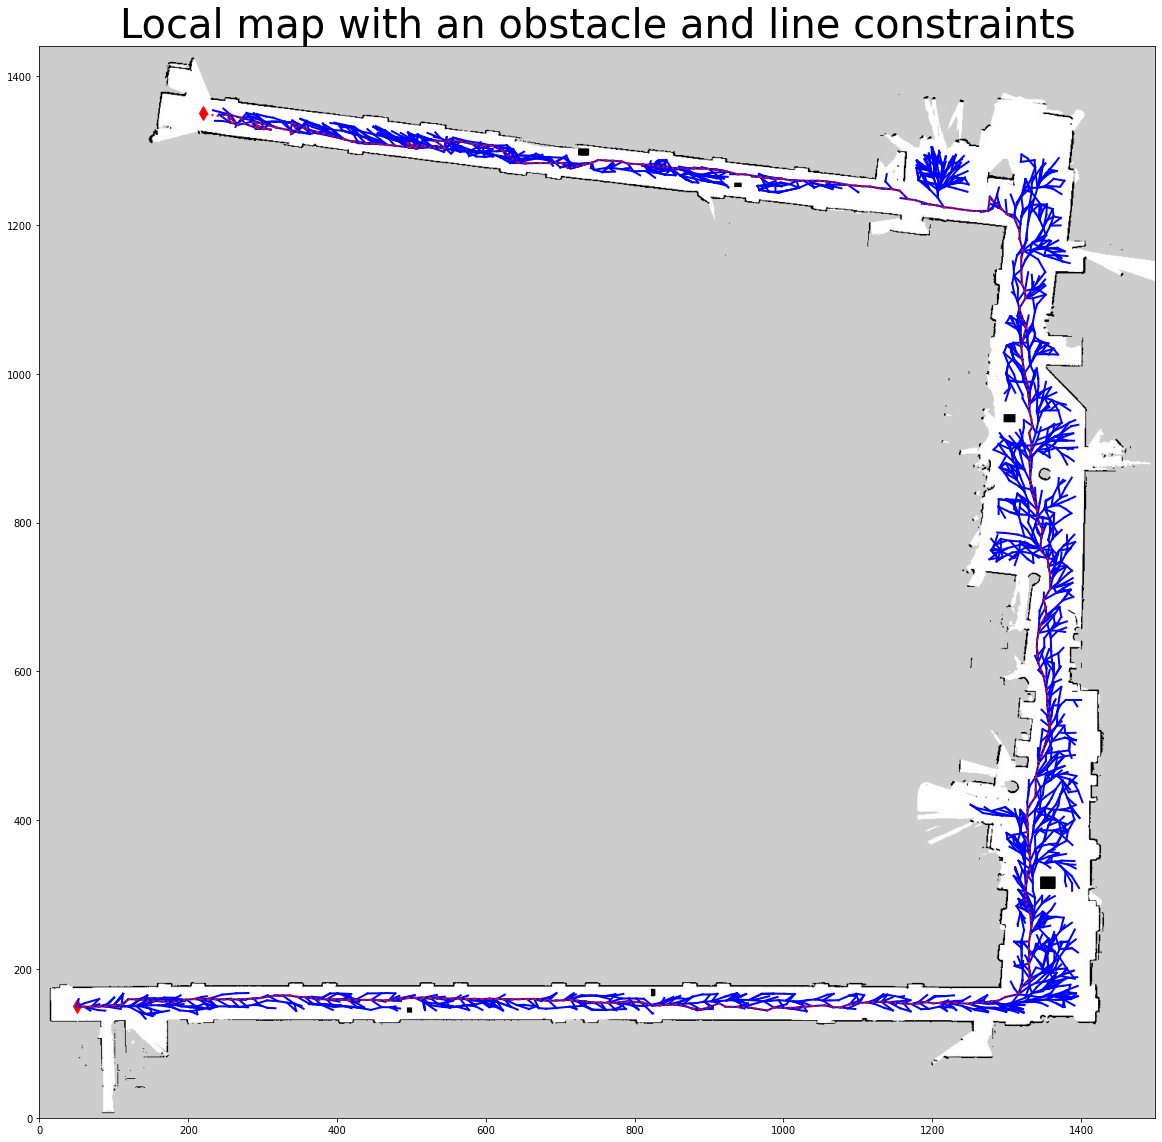

In [16]:
if __name__ == "__main__":
    station()    